In [7]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/mmd_flow_cubature")

import sys
sys.path.append("/home/zongchen/mmd_flow_cubature")
from mmd_flow.distributions import Distribution
from mmd_flow.kernels import gaussian_kernel
from mmd_flow.mmd import mmd_fixed_target
from mmd_flow.gradient_flow import gradient_flow
import mmd_flow.utils
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from tqdm import tqdm

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=16, labelsize=18, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [8]:
bandwidth = 1.0
kernel = gaussian_kernel(bandwidth)
covariances = jnp.load('data/mog_covs.npy')
means = jnp.load('data/mog_means.npy')
k = 20
weights = jnp.ones(k) / k
dim = 2
distribution = Distribution(kernel=kernel, means=means, covariances=covariances, integrand_name='neg_exp', weights=weights)


In [9]:
import numpy as np
import numpy.linalg as la

def closed_form_expression(x, mu, Sigma, ell):
    """
    Computes the user-provided closed form:
    
    det(2 ell^{-2} Sigma + I)^(-1/2)
    * exp(-1/2 mu^T Sigma^{-1} mu)
    * exp( -ell^{-2} ||x||^2
           + 1/2 [ (2 ell^{-2} x - Sigma^{-1} mu)^T (2 ell^{-2} I + Sigma^{-1})^{-1} (2 ell^{-2} x - Sigma^{-1} mu ) ]
         )
    * [ -2 ell^{-2} x
        + 2 ell^{-2} (2 ell^{-2} I + Sigma^{-1})^{-1} (2 ell^{-2} x - Sigma^{-1} mu)
      ]
      
    which is a d-dimensional vector in x.
    """
    d = len(x)
    invSigma = la.inv(Sigma)
    A = invSigma + (1.0/(ell**2)) * np.eye(d)
    invA = la.inv(A)
    
    # We can compute that piece exactly as user wrote:
    #   det(2 ell^{-2} Sigma + I)^{ -1/2 }
    # which is det(A Sigma^{-1})^{ -1/2 } if we like. We'll do it directly:
    det_part = la.det((1.0/(ell**2))*Sigma + np.eye(d))**(-0.5)
    
    # exponent part 1: exp(-1/2 mu^T Sigma^{-1} mu)
    exp1 = np.exp(-0.5 * (mu.T @ invSigma @ mu))
    
    # exponent part 2:
    #    - ell^{-2} ||x||^2
    #  + 1/2 [ (2 ell^{-2} x - Sigma^{-1} mu)^T invA (2 ell^{-2} x - Sigma^{-1} mu ) ]
    two_linv2_x = (1.0/(ell**2))*x
    # Actually the expression is: (2 ell^{-2} x - Sigma^{-1} mu)
    # so let's define that vector:
    b_vec = two_linv2_x + (invSigma @ mu)
    exponent2 = (
        - 0.5 * (1.0/(ell**2)) * (x.T @ x)
        + 0.5 * (b_vec.T @ invA @ b_vec)
    )
    exp2 = np.exp(exponent2)
    
    # the bracketed vector term:
    #    [ -2 ell^{-2} x
    #      + 2 ell^{-2} invA (2 ell^{-2} x - Sigma^{-1} mu )
    #    ]
    bracket_term = (
        -(1.0/(ell**2))*x
        + (1.0/(ell**2)) * (invA @ b_vec)
    )

    return det_part * exp1 * exp2 * bracket_term

d = 3
ell = 1.0
mu  = np.array([0.5, -0.2, 1.0])
# random positive-definite Sigma
A_rand = np.random.randn(d, d)
Sigma = A_rand @ A_rand.T + 0.5*np.eye(d)  # ensures PD
x = np.array([1.0, 2.0, -1.0])

# Number of Monte Carlo samples
N = 3_000_000

# Sample from N(mu, Sigma)
Y = np.random.multivariate_normal(mu, Sigma, size=N)

diff = Y - x[None, :]
diff_sq = np.sum(diff**2, axis=1)
part_1 = np.exp(- 0.5 * (ell**-2) * diff_sq)
part_2 = - (ell**-2) * (x[None, :] - Y)
mc_estimate = (part_1[:, None] * part_2).mean(0)

# Closed form
cf = closed_form_expression(x, mu, Sigma, ell)

print("MC estimate:", mc_estimate)
print("Closed form:", cf)

MC estimate: [-0.00795146 -0.04095103  0.01189402]
Closed form: [-0.00792295 -0.04102362  0.01188393]


In [10]:

def exact_integral(distribution, rate, trajectory):
    ell = 1.0
    diff_exact_list = []

    # This is the integral with exact approximation
    for i in range(0, trajectory.shape[0], rate):
        x = trajectory[i, 0, :]
        # Compute the closed-form solution using the provided formula

        closed_form = 0 
        for j in range(distribution.k):
            mu = distribution.means[j, :]
            Sigma = distribution.covariances[j, :, :]
            closed_form += distribution.weights[j] * closed_form_expression(x, mu, Sigma, ell).squeeze()

        # Compute the integral using numerical integration
        y = trajectory[i, :, :]
        diff = y - x[None, :]
        diff_sq = np.sum(diff**2, axis=1)
        part_1 = np.exp(- 0.5 * (ell**(-2)) * diff_sq)
        part_2 = -(ell**(-2)) * (x[None, :] - y)
        mc_estimate = (part_1[:, None] * part_2).mean(0)

        diff_exact = jnp.abs(closed_form.sum() - mc_estimate.sum())
        diff_exact_list.append(diff_exact)
    return np.array(diff_exact_list)


In [11]:
rate = 1
# particle_num_list = [10, 30, 100, 300, 1000]
# particle_num_list = [10, 30, 100]
particle_num_list = [10, 30, 100]
step_num_list = [10000, 300000, 30000000]
step_size_list = [1.0, 1.0, 2.0]
seed_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

diff_dict = {}
for e, particle_num in tqdm(enumerate(particle_num_list)):
    
    for seed in seed_numbers:
        dir_path = f"/home/zongchen/mmd_flow_cubature/results/mmd_flow/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_{step_size_list[e]}__bandwidth_1.0__step_num_{step_num_list[e]}__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}/"
        trajectory = np.load(dir_path + f'Ys.npy')
        if seed == 0:
            diff_dict[particle_num] = np.zeros((len(seed_numbers), trajectory.shape[0]))
            diff_dict[particle_num][seed, :] = exact_integral(distribution, rate, trajectory)
        else:
            diff_dict[particle_num][seed, :] = exact_integral(distribution, rate, trajectory)
            

0it [00:00, ?it/s]

3it [00:56, 19.00s/it]


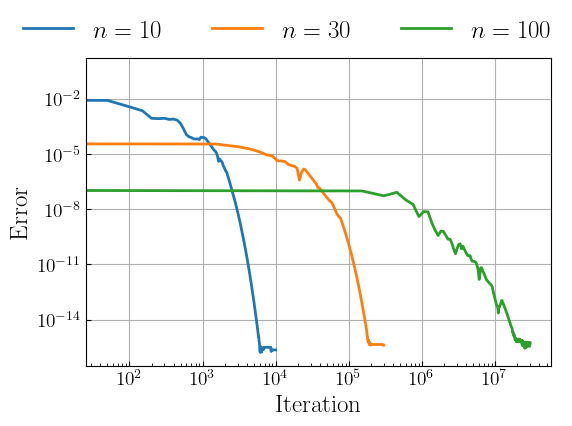

In [ ]:
frames = 200
import matplotlib.pyplot as plt
plt, axs = plt.subplots(1, 1, figsize=(6, 4))
for e, particle_num in enumerate(particle_num_list):
    mean_diff = np.median(diff_dict[particle_num], axis=0)
    axs.plot(np.arange(0, step_num_list[e], step_num_list[e]//200), mean_diff, label=fr'$n={particle_num}$')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel(r'Iteration $T$')
axs.set_ylabel('Cubature Error')
axs.legend(bbox_to_anchor=(1.05, 1.2), loc='upper right', ncol=3)
plt.savefig('figures/exactness.pdf')
plt.show()